# English to Arabic Translation 

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import torch
import random
import re
import os
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.ar import Arabic
import torch
import torch.nn as nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torchtext import data
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

c:\Users\pc\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Processing

In [28]:
df = pd.read_csv("data/arabic_english.txt",delimiter="\t",names=["eng","ar"])
# remove duplicates
df = df.drop_duplicates(subset=['eng','ar'],keep='first')
df

,eng,ar
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!
...,...,...
24633,rising voices promoting a more linguistically ...,شاركنا تحدي ابداع ميم بلغتك الام تعزيزا للتنوع...
24634,following last year s successful campaign we i...,استكمالا لنجاح حملة العام السابق ندعوكم للمشار...
24635,during last year s challenge we also met langu...,تعرفنا خلال تحدي العام الماضي على ابطال لغويين...
24636,to take part just follow the simple steps outl...,للمشاركة في التحدي اتبع الخطوات الموضحة على ال...


In [3]:
#!python -m spacy download en_core_web_sm

### tokenizers

In [29]:
seed=42
spacy_eng = spacy.load("en_core_web_sm")
arab = Arabic()
ar_Tokenizer = Tokenizer(arab.vocab)

def engTokenizer(text):
 return  [word.text for word in spacy_eng.tokenizer(text)] 

def arTokenizer(sentence):
    return  [word.text for word in ar_Tokenizer(re.sub(r"\s+"," ",re.sub(r"[\.\'\"\n+]"," ",sentence)).strip())]

SRC = data.Field(tokenize=engTokenizer,batch_first=False,init_token="<sos>",eos_token="<eos>")
TRG = data.Field(tokenize=arTokenizer,batch_first=False,tokenizer_language="ar",init_token="بداية",eos_token="نهاية")

class TextDataset(data.Dataset):

    def __init__(self, df, src_field, target_field, is_test=False, **kwargs):
        fields = [('eng', src_field), ('ar',target_field)]
        samples = []
        for i, row in df.iterrows():
            eng = row.eng 
            ar = row.ar
            samples.append(data.Example.fromlist([eng, ar], fields))

        super().__init__(samples, fields, **kwargs)
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        return self.samples[idx]

torchdataset = TextDataset(df,SRC,TRG)

train_data, valid_data = torchdataset.split(split_ratio=0.8, random_state = random.seed(seed))

SRC.build_vocab(train_data,min_freq=2)
TRG.build_vocab(train_data,min_freq=2)

print(train_data[1].__dict__)


{'eng': ['Let', "'s", 'just', 'be', 'friends', '.'], 'ar': ['دعنا', 'فقط', 'نصبح', 'أصدقاء']}


### seting up the device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))
# !nvidia-smi

cuda
NVIDIA GeForce RTX 3080 Ti


In [ ]:
class Transformer(nn.Module):
    def __init__(self,embedding_size,src_vocab_size,trg_vocab_size,src_pad_idx,num_heads,num_encoder_layers,num_decoder_layers,max_len,):
        super(Transformer, self).__init__()
        self.src_embeddings = nn.Embedding(src_vocab_size,embedding_size)
        self.src_positional_embeddings= nn.Embedding(max_len,embedding_size)
        self.trg_embeddings= nn.Embedding(trg_vocab_size,embedding_size)
        self.trg_positional_embeddings= nn.Embedding(max_len,embedding_size)
        self.device = device
        self.transformer = nn.Transformer(embedding_size,num_heads,num_encoder_layers,num_decoder_layers,)
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(0.1)
        self.src_pad_idx = src_pad_idx
    
    def make_src_mask(self, src):
        src_mask = src.transpose(0,1) == self.src_pad_idx
        return src_mask.to(device)

    def forward(self,src,trg) :
        src_seq_length, S = src.shape
        trg_seq_length, S = trg.shape
        #adding zeros is an easy way
        src_positions = (torch.arange(0, src_seq_length).unsqueeze(1).expand(src_seq_length, S).to(self.device))
        trg_positions = (torch.arange(0, trg_seq_length).unsqueeze(1).expand(trg_seq_length, S).to(self.device))
        embed_src  = self.dropout(( self.src_embeddings(src) + self.src_positional_embeddings(src_positions)))
        embed_trg = self.dropout(( self.trg_embeddings(trg) + self.trg_positional_embeddings(trg_positions)))
        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(device)
        out = self.transformer(embed_src,embed_trg, src_key_padding_mask=src_padding_mask,tgt_mask=trg_mask )
        out= self.fc_out(out)
        return out

In [ ]:
train_iter, valid_iter = data.BucketIterator.splits((train_data,valid_data), batch_size = BATCH_SIZE,sort=None,sort_within_batch=False,sort_key=lambda x: len(x.eng),device=device,shuffle=True)

In [ ]:
load_model = False
save_model = True
BATCH_SIZE = 16 
learning_rate = 0.0001
num_epochs = 30
# Model
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
max_len= 230
dropout = 0.4
embedding_size= 256
src_pad_idx = SRC.vocab.stoi["<pad>"]
src_vocab_size  = len(SRC.vocab)
print("Size of english vocabulary:",src_vocab_size)
trg_vocab_size =len(TRG.vocab)
print("Size of arabic vocabulary:",trg_vocab_size)
model = Transformer(embedding_size,src_vocab_size,trg_vocab_size,src_pad_idx,num_heads,num_encoder_layers,num_decoder_layers,max_len,).to(device)



Size of english vocabulary: 12766
Size of arabic vocabulary: 21981


In [ ]:
print(model)

Transformer(
  (src_embeddings): Embedding(12766, 256)
  (src_positional_embeddings): Embedding(230, 256)
  (trg_embeddings): Embedding(21981, 256)
  (trg_positional_embeddings): Embedding(230, 256)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (sel

In [ ]:
torch.cuda.empty_cache()

In [ ]:
loss_track = []
loss_validation_track= []
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
pad_idx = SRC.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)
for epoch in range(num_epochs):
    stepLoss=[]
    model.train()
    for batch  in train_iter:
        input_data = batch.eng.to(device)
        target = batch.ar.to(device)
        output = model(input_data,target[:-1])
        optimizer.zero_grad()       
        output = output.reshape(-1,trg_vocab_size)
        target = target[1:].reshape(-1)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        stepLoss.append(loss.item())
    loss_track.append(np.mean(stepLoss))
    print(" Epoch {} | Train Cross Entropy Loss: ".format(epoch),np.mean(stepLoss))
    with torch.no_grad():    
      stepValidLoss=[]
      model.eval() # the evaluation mode for the model (doesn't apply dropout and batchNorm)
      for i,batch  in enumerate(valid_iter):
            input_sentence = batch.eng.to(device)
            target = batch.ar.to(device)
            optimizer.zero_grad()
            output = model(input_sentence,target[:-1])
            output = output.reshape(-1,trg_vocab_size)
            target = target[1:].reshape(-1)
            loss = criterion(output,target)             
            stepValidLoss.append(loss.item())  
    loss_validation_track.append(np.mean(stepValidLoss))
    print(" Epoch {} | Validation Cross Entropy Loss: ".format(epoch),np.mean(stepValidLoss))  

 Epoch 0 | Train Cross Entropy Loss:  7.486914330091172
 Epoch 0 | Validation Cross Entropy Loss:  6.143818473504259
 Epoch 1 | Train Cross Entropy Loss:  7.000222254541446
 Epoch 1 | Validation Cross Entropy Loss:  5.8936981999017055
 Epoch 2 | Train Cross Entropy Loss:  6.728391125200226
 Epoch 2 | Validation Cross Entropy Loss:  5.72275688445646
 Epoch 3 | Train Cross Entropy Loss:  6.478139531309735
 Epoch 3 | Validation Cross Entropy Loss:  5.572155557426751
 Epoch 4 | Train Cross Entropy Loss:  6.237511396212816
 Epoch 4 | Validation Cross Entropy Loss:  5.474729069697312
 Epoch 5 | Train Cross Entropy Loss:  5.997134029035388
 Epoch 5 | Validation Cross Entropy Loss:  5.367053468242969
 Epoch 6 | Train Cross Entropy Loss:  5.768872600027423
 Epoch 6 | Validation Cross Entropy Loss:  5.364213545338001
 Epoch 7 | Train Cross Entropy Loss:  5.5389819219403345
 Epoch 7 | Validation Cross Entropy Loss:  5.30028329955207
 Epoch 8 | Train Cross Entropy Loss:  5.3093830611645245
 Epoch 

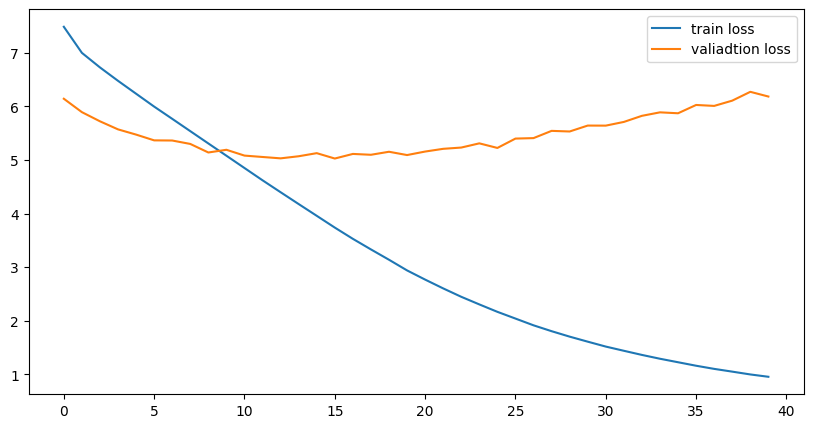

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(30),loss_track,label="train loss")
plt.plot(range(30),loss_validation_track,label="valiadtion loss")
plt.legend()
plt.show()  

In [ ]:
def translate_sentence(model,sentence,srcField,targetField,srcTokenizer):
    model.eval()
    processed_sentence = srcField.process([srcTokenizer(sentence)]).to(device)
    trg = ["بداية"]
    for _ in range(60):
        trg_indecies = [targetField.vocab.stoi[word] for word in trg]
        trg_tensor = torch.LongTensor(trg_indecies).unsqueeze(1).to(device)
        outputs = model(processed_sentence,trg_tensor)    
        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "<unk>":
            continue 
        trg.append(targetField.vocab.itos[outputs.argmax(2)[-1:].item()])
        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "نهاية":
            break
    return " ".join([word for word in trg if word != "<unk>"][1:-1])


In [ ]:
translate_sentence(model,"I am ready" ,SRC,TRG,engTokenizer)

'أنا'

In [ ]:
translate_sentence(model,"I am lucky" ,SRC,TRG,engTokenizer)

'انا اري'

In [ ]:
translate_sentence(model,"I am sad" ,SRC,TRG,engTokenizer)

''

In [ ]:
translate_sentence(model,"I am happy" ,SRC,TRG,engTokenizer)


'انا سعيد سعيد'

In [ ]:
translate_sentence(model,"I am angry" ,SRC,TRG,engTokenizer)

''

In [ ]:
translate_sentence(model,"I am tired" ,SRC,TRG,engTokenizer)

''

In [ ]:
translate_sentence(model,"I am hungry" ,SRC,TRG,engTokenizer)

'أشعر بالجوع'

In [ ]:
translate_sentence(model,"I am going outside" ,SRC,TRG,engTokenizer)

''

In [ ]:
translate_sentence(model,"I am going to the market" ,SRC,TRG,engTokenizer)

''

In [ ]:
translate_sentence(model,"He is here" ,SRC,TRG,engTokenizer)

'هنا'

In [ ]:
translate_sentence(model,"He is not here" ,SRC,TRG,engTokenizer)

'ليس هنا'

In [ ]:
translate_sentence(model,"I am not at home" ,SRC,TRG,engTokenizer)

'لا يوجد في المنزل'

In [ ]:
from transformers import MarianMTModel, MarianTokenizer
model_name = "Helsinki-NLP/opus-mt-en-ar"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

english_text = "egypt muslim world journal of human rights global voices."

# Tokenize the input
encoded_input = tokenizer.encode(english_text, return_tensors="pt")

# Translate the input
translated = model.generate(encoded_input)

# Decode the translated output
arabic_text = tokenizer.decode(translated[0], skip_special_tokens=True)
print(arabic_text)


مجلة العالم الإسلامي لحقوق الإنسان للأصوات العالمية لحقوق الإنسان.


In [3]:
import torch
from transformers import MarianMTModel, MarianTokenizer, AdamW
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, file_path, tokenizer):
        self.data = []
        self.tokenizer = tokenizer

        # Read and process the dataset file
        with open(file_path, "r", encoding="utf-8") as file:
            lines = file.readlines()
            for line in lines:
                pair = line.strip().split("\t")
                if len(pair) == 2:
                    source_text = pair[0].strip()
                    target_text = pair[1].strip()
                    self.data.append((source_text, target_text))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        source_text, target_text = self.data[idx]
        source_inputs = self.tokenizer.encode(source_text, padding="longest", truncation=True, return_tensors="pt")
        target_inputs = self.tokenizer.encode(target_text, padding="longest", truncation=True, return_tensors="pt")
        return source_inputs.squeeze(), target_inputs.squeeze()
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set up the model and tokenizer
model_name = "Helsinki-NLP/opus-mt-en-ar"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)
# Prepare your training dataset
# split the dataset into train and validation sets
train_dataset = TranslationDataset("data/arabic_english.txt", tokenizer)
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
print("length of training dataset:", len(train_dataset))
print("length of validation dataset:", len(valid_dataset))

c:\Users\pc\anaconda3\lib\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


length of training dataset: 19710
length of validation dataset: 4928


In [37]:
# Set up your training hyperparameters
batch_size = 64
learning_rate = 1e-5
num_epochs = 10
# Set the model to train mode
model.train()

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
total_loss = 0.0
batch_count = 0

for epoch in range(num_epochs):
    for idx in range(len(train_dataset)):
        source_inputs, target_inputs = train_dataset[idx]
        source_inputs = source_inputs.unsqueeze(0).to(model.device)
        target_inputs = target_inputs.unsqueeze(0).to(model.device)

        # Forward pass
        outputs = model(input_ids=source_inputs, labels=target_inputs)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1

        # Print average loss every 100 batches
        if batch_count % 100 == 0:
            average_loss = total_loss / 100
            print(f"Epoch {epoch+1}/{num_epochs} - Batch {batch_count} - Loss: {average_loss:.4f}")
            total_loss = 0.0

# Save the fine-tuned model
model.save_pretrained("translator_model")
tokenizer.save_pretrained("translator_model")

# Set up the model and tokenizer
model_name = "translator_model"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)



c:\Users\pc\anaconda3\lib\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
c:\Users\pc\anaconda3\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Batch 100 - Loss: 3.2364
Epoch 1/10 - Batch 200 - Loss: 1.9338
Epoch 1/10 - Batch 300 - Loss: 1.3395
Epoch 1/10 - Batch 400 - Loss: 1.2951
Epoch 1/10 - Batch 500 - Loss: 1.0964
Epoch 1/10 - Batch 600 - Loss: 1.0777
Epoch 1/10 - Batch 700 - Loss: 1.0991
Epoch 1/10 - Batch 800 - Loss: 0.9989
Epoch 1/10 - Batch 900 - Loss: 0.9804
Epoch 1/10 - Batch 1000 - Loss: 0.9773
Epoch 1/10 - Batch 1100 - Loss: 0.9402
Epoch 1/10 - Batch 1200 - Loss: 0.8626
Epoch 1/10 - Batch 1300 - Loss: 0.9564
Epoch 1/10 - Batch 1400 - Loss: 0.7271
Epoch 1/10 - Batch 1500 - Loss: 0.8559
Epoch 1/10 - Batch 1600 - Loss: 0.8294
Epoch 1/10 - Batch 1700 - Loss: 0.7642
Epoch 1/10 - Batch 1800 - Loss: 0.8184
Epoch 1/10 - Batch 1900 - Loss: 0.8525
Epoch 1/10 - Batch 2000 - Loss: 0.8868
Epoch 1/10 - Batch 2100 - Loss: 0.6263
Epoch 1/10 - Batch 2200 - Loss: 0.8006
Epoch 1/10 - Batch 2300 - Loss: 0.8213
Epoch 1/10 - Batch 2400 - Loss: 0.8269
Epoch 1/10 - Batch 2500 - Loss: 0.6837
Epoch 1/10 - Batch 2600 - Loss: 0.

c:\Users\pc\anaconda3\lib\site-packages\transformers\generation\utils.py:1346: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


مصر المجلة العالمية لحقوق الانسان الاصوات العالمية


In [40]:
# Translate a sentence
english_text = "you will also find links to some free web based platforms to \
create and save your creations in the week prior to international mother language day we ll be sharing retweeting and liking contributions \
from around the world and featuring some of our favorites here on rising voices."
encoded_input = tokenizer.encode(english_text, return_tensors="pt")
translated = model.generate(encoded_input)
arabic_text = tokenizer.decode(translated[0], skip_special_tokens=True)
print(arabic_text)

ستجدون ايضا روابط لبعض المنصات المجانية على الانترنت لانشاء وانقاذ ابتكاراتكم في قبل اسبوع من اليوم العالمي للغة الام سنشارك مساهماتنا من جميع انحاء العالم ونعرض بعض المفضلين هنا على الاصوات الصاعدة


In [8]:
import torch
from transformers import MarianMTModel, MarianTokenizer, AdamW
from torch.utils.data import Dataset
# translate a file
english_file = "data/english_test.txt"
arabic_file = "data/arabic_output.txt"
#use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set up the model and tokenizer
model_name = "translator_model"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)


# Read the file
with open(english_file, "r", encoding="utf-8") as file:
    lines = file.readlines()
    english_texts = [line.strip() for line in lines]

# Translate the texts
arabic_texts = []
for english_text in english_texts:
    encoded_input = tokenizer.encode(english_text, return_tensors="pt").to(device)
    translated = model.generate(encoded_input)
    arabic_text = tokenizer.decode(translated[0], skip_special_tokens=True)
    arabic_texts.append(arabic_text)
    # write each translated text to the file
    with open(arabic_file, "a", encoding="utf-8") as file:
        file.write(arabic_text + "\n")



            

In [ ]:
model.eval()

# Paths for the output files
validation_dataset_file = "./data/english_validation_dataset.txt"
translations_file = "./data/translations.txt"
model_outputs_file = "./data/model_outputs.txt"

# Open the files in write mode
with open(validation_dataset_file, "w", encoding="utf-8") as dataset_file, \
        open(translations_file, "w", encoding="utf-8") as translations_output_file:

    for idx in range(len(valid_dataset)):
        source_inputs, target_inputs = valid_dataset[idx]
        source_sentence = tokenizer.decode(source_inputs, skip_special_tokens=True, clean_up_tokenization_spaces=False)
        target_sentence = tokenizer.decode(target_inputs, skip_special_tokens=True, clean_up_tokenization_spaces=False)

        # Remove underscores from the sentences
        source_sentence = source_sentence.replace("▁", " ").strip()
        target_sentence = target_sentence.replace("▁", " ").strip()

        # Write English validation dataset to file
        dataset_file.write(source_sentence + "\n")

        # Write translations to file
        translations_output_file.write(target_sentence + "\n")

print("Validation dataset and translations written successfully.")

# Read the validation dataset
with open(validation_dataset_file, "r", encoding="utf-8") as dataset_file:
    validation_sentences = dataset_file.readlines()

# Initialize an empty list to store the generated translations
generated_translations = []

# Generate translations using the model
for sentence in validation_sentences:
    input_ids = tokenizer.encode(sentence, padding=True, truncation=True, max_length=512, return_tensors="pt")
    input_ids = input_ids.to(device)
    translation = model.generate(input_ids)
    translated_sentence = tokenizer.decode(translation[0], skip_special_tokens=True)
    generated_translations.append(translated_sentence)

# Write the model output to a file
with open(model_outputs_file, "w", encoding="utf-8") as output_file:
    output_file.write("\n".join(generated_translations))

# Compare the generated translations with the ground truth translations for accuracy
with open(translations_file, "r", encoding="utf-8") as translations_file:
    ground_truth_translations = translations_file.readlines()


In [47]:
num_correct = 0
total = len(ground_truth_translations)
for generated_translation, ground_truth_translation in zip(generated_translations, ground_truth_translations):
    generated_words = generated_translation.strip().split()
    ground_truth_words = ground_truth_translation.strip().split()
    common_words = set(generated_words).intersection(ground_truth_words)
    if len(common_words) >= len(ground_truth_words) * 0.35:
        num_correct += 1

accuracy = num_correct / total
print("Accuracy: {:.2%}".format(accuracy))




Accuracy: 37.03%


In [46]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the ground truth translations
ground_truth_vectors = vectorizer.fit_transform(ground_truth_translations)

num_correct = 0
total = len(ground_truth_translations)

for generated_translation, ground_truth_vector in zip(generated_translations, ground_truth_vectors):
    generated_vector = vectorizer.transform([generated_translation])
    similarity = cosine_similarity(generated_vector, ground_truth_vector)
    if similarity > 0.35:  # Adjust the threshold as per your requirement
        num_correct += 1

accuracy = num_correct / total
print("Accuracy: {:.2%}".format(accuracy))


Accuracy: 52.54%
